In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt  # seaborn is based on matplotlib
sns.set(color_codes=True) # adds a nice background to the graphs
%matplotlib inline 
import gurobipy as gp
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('training_data.csv')
test_data = pd.read_csv('test_data.csv')
X_train = train_data.loc[:, train_data.columns != 'y']
y_train = train_data['y']

X_test = test_data.loc[:, test_data.columns != 'y']
y_test = test_data['y']
X_train[:2]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,0.865598,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,1.838930,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453


## Set parameters

In [3]:
# Set M to a large number
M = 100
m = 50
k = [z for z in range(5,55,5)]
time = 3600

## Define a function to get beta

In [4]:
def get_beta(X_train,y_train,k):
    '''
    Input variables: 
        train_x is the x1 to x50 in the training dataset, 
        train_y is the y column in the training dataset
        k is the number of variables to use to be added to the constraint matrix
    Function:
        use gurobi to find optimal coefficients (betas) of X (and set time limit)
    return: 
        a list of betas to be used in cv
    '''
    # Create X and XTX
    X_df = np.array(X_train)
    Y = np.array(y_train)
    #ones = np.ones((250,1))
    ones = [1] * len(X_df)
    X = np.insert(X_df, 0, ones, axis=1)
    #X = np.hstack((ones,X_df))
    XTX = X.T@X
    
    # Create Q
    m = 50
    Q = np.zeros((2*m+1,2*m+1))
    Q[0:m+1,0:m+1] = XTX
    
    # define linear term c
    X_linear = np.zeros((len(X), 2*m+1))
    X_linear[0:len(X), 0:m+1] = X
    c = -2 * Y.T @ X_linear
    
    # Constraint lhs
    A = np.zeros((2*m+1, 2*m+1))
    A[:,0] = 0
    A[0:m, 1:m+1] = np.diag(np.ones(m))
    A[0:m, m+1:2*m+1] = np.diag(np.ones(m))*M
    A[m:2*m, 1:m+1] = np.diag(np.ones(m))
    A[m:2*m, m+1:2*m+1] = np.diag(np.ones(m))*(-M)
    A[2*m:2*m+1, m+1:2*m+1] = [1]*m

    # Constraint rhs
    b = np.array([0]*(2*m+1))
    b[-1] = k

    # define optimization sense
    sense = np.array(['>']*m + ['<']*(m+1))
    lb = [-M]*(m+1) + [0]*m
    ub = [M]*(m+1) + [1]*m
    MIQPMod = gp.Model()
    MIQPMod_x = MIQPMod.addMVar(2*m+1,vtype=['C']*(m+1)+['B']*m, lb=lb, ub=ub)
    MIQPMod_con = MIQPMod.addMConstrs(A, MIQPMod_x, sense, b)
    MIQPMod.setMObjective(Q,c,0,sense=gp.GRB.MINIMIZE)

    MIQPMod.Params.TimeLimit = time
    MIQPMod.Params.OutputFlag = False
    MIQPMod.optimize()

    loss = MIQPMod.objVal
    
    return MIQPMod_x.x[:m+1]

## Cross Validation

In [5]:
def get_k_folds():
    # shuffle data into 10 folds
    num_folds = 10 
    size_of_fold = len(y_train) / num_folds
    indices = np.arange(len(y_train))
    folds_indices = []
    for i in range(0, num_folds):
        fold = list(np.random.choice(indices, int(size_of_fold)))
        #removes randomly chosen indices in fold from original set to avoid double-dipping
        indices = [x for x in indices if x not in fold]
        folds_indices.append(fold)
    return np.array(folds_indices)

In [6]:
def cross_validate(X, y, k):
    folds_indices = get_k_folds()
    sse_results = []
    coefs = []
    for i in range(0, len(folds_indices)):
        #split into train (1 fold) and test (9 folds)
        test_index = folds_indices[i]
        train_index = [x for x in folds_indices.flatten() if x not in folds_indices[i]]
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #get betas
        betas = get_beta(X_train, y_train, k) #calls function that runs gurobi 
        #get sse
        coefs.append(betas)
        
        ## SSE = (X*Beta - Y)T(X*Beta - Y), X is the original X matrix with addition column of 1
        ones = [1] * len(X_test)
        X_test_new = X_test.copy()
        X_test_new.insert(0, 'X0', ones)

        sse = np.sum(((X_test_new @ betas) - y_test)**2)
        sse_results.append(sse)
        
    sum_sse = np.mean(sse_results)
    return sum_sse, coefs

## Find the optimal k

In [7]:
# cv over values of k
k_vals = np.arange(start=5, stop=55, step=5)
sse_measures = []
betas_vals = []
for k in k_vals:
    sse, coefs = cross_validate(X_train, y_train, k)
    betas_vals.append(coefs)
    sse_measures.append(sse)

Academic license - for non-commercial use only - expires 2022-09-15
Using license file /Users/Kaushik Kumaran/gurobi.lic
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLi

Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 3600.0
   Prev: inf 

In [8]:
min_sse = min(sse_measures)
min_k = 0
best_betas = []
for i in range(0, len(sse_measures)):
    if (sse_measures[i] == min_sse):
        min_k = k_vals[i]
        best_betas = betas_vals[i]

In [9]:
print(min_k)

15


In [10]:
best_betas

[array([ 1.0111942 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -2.27027241,
         0.        ,  0.        ,  0.        ,  0.27790389,  0.        ,
        -0.31213971, -0.15199518,  0.        ,  0.        , -0.3144918 ,
         0.        ,  0.        ,  0.        , -1.8511432 ,  0.93126823,
         0.        , -1.4766625 ,  0.        ,  0.        ,  0.        ,
         0.29129376,  0.        ,  0.        ,  0.        ,  0.42166748,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.21272293,  0.        ,  0.        ,  0.        ,  0.381298  ,
         1.58498256,  0.        ,  1.28580657, -0.48637736,  0.        ,
         0.        ]),
 array([ 0.99631513,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.34649295,  0.        ,  0.        , -2.20052569,
         0.        , -0.28754921,  0.        ,  0.        ,  0.        ,
        -0.5248384 ,  0.    

In [11]:
betas = get_beta(X_train, y_train, min_k)
coefs.append(betas)

ones = [1] * len(X_test)
X_test_new = X_test.copy()
X_test_new.insert(0, 'X0', ones)

sse = np.sum(((X_test_new @ betas) - y_test)**2)
        
sse

Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


118.81971874224348

In [12]:
from sklearn.linear_model import LassoCV

reg = LassoCV(cv=10, random_state=42).fit(X_train, y_train)
print(reg.alpha_)
y_pred = reg.predict(X_test)
sse_lasso = np.sum((y_pred - y_test)**2)
print(sse_lasso)

0.07638765995113514
117.48173795802899


In [13]:
reg.coef_

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -2.16054765,  0.        ,
       -0.05964031, -0.        , -0.        , -0.        , -0.41912484,
       -0.19325408,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.19517759, -1.36388738,  0.7425965 , -0.        ,
       -1.30481574, -0.        ,  0.        ,  0.05798283,  0.        ,
       -0.        ,  0.        , -0.09737839,  0.28341629,  0.        ,
        0.        ,  0.        ,  0.        , -0.23157873,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.03078191,  1.56362172,
       -0.02160033,  0.69992447, -0.09289745,  0.        ,  0.        ])

## Visualization

ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

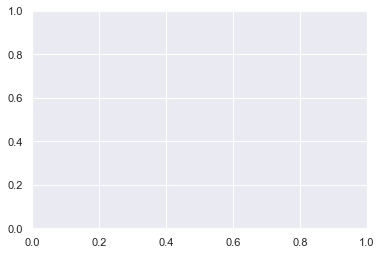

In [14]:
# Plot the SSE of MIQP associated with different k
ax = plt.gca()

ax.plot(k, sse_measures)
# ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::1])
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('SSE of MIQP associated with different k')
plt.axis('tight')
plt.show()

In [ ]:
# # Plot the coefficients of variables and all of the alpha in lasso
# coefs = []
# for alpha in alphas:
#     model = Lasso(alpha)
#     model.fit(X_train, y_train) # Fit the model
#     coefs.append(model.coef_)
    
ax = plt.gca()

ax.plot(reg.coef_, reg.alpha_)
#ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::1])
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()